In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import math
import numpy as np
import seaborn as sns
from matplotlib.colors import LogNorm
import scipy as sp

from effsim.paramgen import uniform_param_generator
from effsim.paramgen import distribution_param_generator
from effsim.effsim import EventSimulator
from effsim.effsim import NoiseMaker

from pytpc.hdfdata import HDFDataFile

import pytpc
from pytpc.tpcplot import pad_plot, chamber_plot
from pytpc.constants import degrees, pi

import csv
import yaml
import h5py

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
##Steps to discretize events##

#generate parameters with uniform_param_generator
#generate simulated event (Python dictionary obect) (COULD ADD NOISE HERE?)  - seems to make more sense during generation
#convert simulated events to Event objects
#write this to our h5

#load h5 file and give it to discretizatio function
#loop through all events in h5 discretizing by taking evt.xyzs (COULD ADD NOISE HERE?)
#save discretized events to sparse csr_matrix

In [15]:
with open('/home/taylor/Documents/independent-research/req-files/config_e15503b_p.yml', 'r') as f:
    config = yaml.load(f)
    
beam_enu0 = config['beam_enu0']
#print(beam_enu0)
beam_mass = config['beam_mass']
beam_charge = config['beam_charge']
mass_num = config['mass_num']
max_beam_angle = (config['max_beam_angle']*math.pi)/180
#print(max_beam_angle)
beam_origin_z = config['beam_origin_z']

gas = pytpc.gases.InterpolatedGas('isobutane', 19.2)

# number of events to create
num_evts = 20

In [16]:
pgen = uniform_param_generator(beam_enu0, beam_mass, beam_charge, mass_num, max_beam_angle, beam_origin_z, gas, num_evts)

In [17]:
p = next(pgen)

# p[0][0] = -0.00791423
# p[0][1] =  0.0030299
# p[0][2] = 0.56803276
# p[0][3] = 1.83097548
# p[0][4] =  0.11137931
# p[0][5] =  2.01473709

print(p)

(array([ 0.00618526, -0.01011947,  0.7892669 ,  2.42300483,  1.62128002,
        2.03993594]), array([ 0.01762516, -0.02883587, -0.99942876]))


In [18]:
sim = EventSimulator(config)

In [19]:
evt, ctr = sim.make_event(p[0][0], p[0][1], p[0][2], p[0][3], p[0][4], p[0][5])
print(len(evt))

607


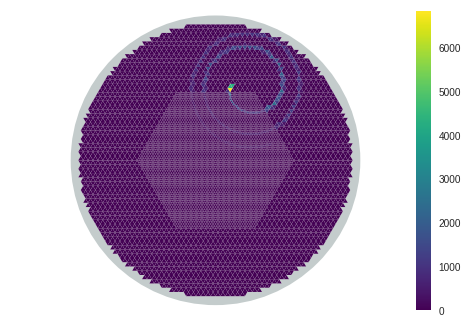

In [20]:
hits = np.zeros(10240)
for k, v in evt.items():
    hits[k] += v.max()
        
fig, sm = pad_plot(hits, scale='linear', cmap='viridis')
plt.colorbar(sm)

# Adding Random Noise

In [21]:
print(type(evt))

<class 'dict'>


In [22]:
#print(evt.keys())

dict_keys([776, 777, 779, 782, 784, 785, 787, 790, 792, 793, 795, 798, 800, 801, 803, 806, 808, 809, 811, 1041, 1042, 1044, 1046, 1047, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1067, 1069, 1070, 1072, 1075, 1077, 1078, 1080, 1083, 1085, 1086, 1088, 1091, 1093, 1094, 1096, 1098, 1099, 1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1113, 1114, 1116, 1305, 1307, 1308, 1309, 1310, 1312, 1313, 1314, 1315, 1316, 1317, 1318, 1319, 1320, 1321, 1322, 1325, 1327, 1391, 1392, 1394, 1566, 1567, 1569, 1571, 1572, 1573, 1574, 1575, 1576, 1578, 1579, 1581, 1625, 1630, 1822, 1825, 1827, 1828, 1829, 1830, 1831, 1832, 1833, 1834, 1837, 1839, 1862, 1865, 1867, 1868, 1870, 1872, 1873, 1874, 1875, 1876, 1877, 1878, 1879, 1880, 1881, 1882, 1883, 1884, 1885, 1887, 1888, 1890, 1893, 1895, 1896, 1898, 1901, 1903, 1904, 1905, 1906, 1908, 1909, 1910, 1911, 1912, 1913, 1914, 1915, 1916, 1917, 1918, 1921, 1923, 1924, 1926, 2077, 2079, 2080, 

In [23]:
#print(evt.get(148))

In [24]:
pyevt = sim.convert_event(evt)

In [25]:
print(pyevt)

Event 0, timestamp 0.
Contains 607 traces.


In [26]:
print(type(pyevt.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)))

<class 'numpy.ndarray'>


/usr/local/lib/python3.6/site-packages/pytpc-1.1.0-py3.6-linux-x86_64.egg/pytpc/evtdata.py:187: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(peak_data * range_idx, axis=-1) / peak_data.sum(axis=-1)


In [27]:
xyzs = pyevt.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
print(len(xyzs))
print(xyzs.shape)
#print(xyzs)

607
(607, 5)


/usr/local/lib/python3.6/site-packages/pytpc-1.1.0-py3.6-linux-x86_64.egg/pytpc/evtdata.py:187: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(peak_data * range_idx, axis=-1) / peak_data.sum(axis=-1)


In [28]:
#noise requirements:
#x and y: -DETECTOR_RADIUS < __ < +DETECTOR_RADIUS
#z: 0 < __ < DETECTOR_LENGTH

DETECTOR_LENGTH = 1000.0
DETECTOR_RADIUS = 275.0

In [29]:
#add new noise, not just randomly osciallate existing points - np.random.___()

In [30]:
num_noisepts = np.random.randint(20, 300,)    #20-300
print(num_noisepts)

276


In [31]:
#generate x and y based on random pad numbers
paddresses = np.random.randint(0,10240, (num_noisepts, 1))
print(paddresses.shape)

pads = pytpc.generate_pad_plane()
pcenters = pads.mean(1)

xys = pcenters[paddresses].reshape(num_noisepts, 2)
print(xys.shape)
#z and charge values are generated randomly in realistic ranges
zs = np.random.uniform(0, DETECTOR_LENGTH, (num_noisepts, 1))
print(zs.shape)

charges = np.random.uniform(1, 4000, (num_noisepts, 1))  #1-4000
print(charges.shape)

(276, 1)
(276, 2)
(276, 1)
(276, 1)


In [32]:
#note in discretization we do not need to return the pad addresses
noise_mat = np.hstack((xys, zs, charges, paddresses))

In [33]:
#print(noise_mat)

In [34]:
clean_xyzs = xyzs
noise_xyzs = np.vstack((xyzs, noise_mat))

In [35]:
print(clean_xyzs.shape)
print(noise_xyzs.shape)

(607, 5)
(883, 5)


/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


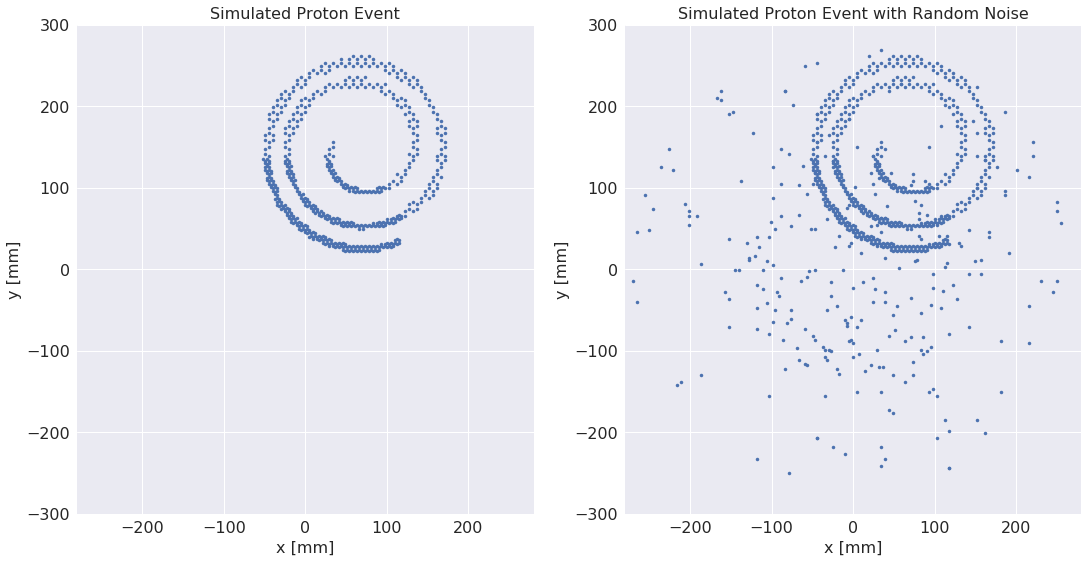

In [72]:
plt.rcParams["axes.labelsize"] = 16
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["xtick.labelsize"] = 16
plt.rcParams["ytick.labelsize"] = 16


fig, ax = plt.subplots(1, 2, squeeze=True, figsize=(18, 9))

ax[0].plot(clean_xyzs[:,0], clean_xyzs[:,1], '.')
ax[0].axis('equal')
        
ax[0].set_xlabel('x [mm]')
ax[0].set_ylabel('y [mm]')
ax[0].set_title('Simulated Proton Event')
ax[0].set_xlim(-300.0, 300.0)
ax[0].set_ylim(-300.0, 300.0)

#######################################################################################################################
ax[1].plot(noise_xyzs[:,0], noise_xyzs[:,1], '.')
ax[1].axis('equal')
        
ax[1].set_xlabel('x [mm]')
ax[1].set_ylabel('y [mm]')
ax[1].set_title('Simulated Proton Event with Random Noise')
ax[1].set_xlim(-300.0, 300.0)
ax[1].set_ylim(-300.0, 300.0)

#plt.savefig('../plots/results/thesis/add-noise-2D.pdf')

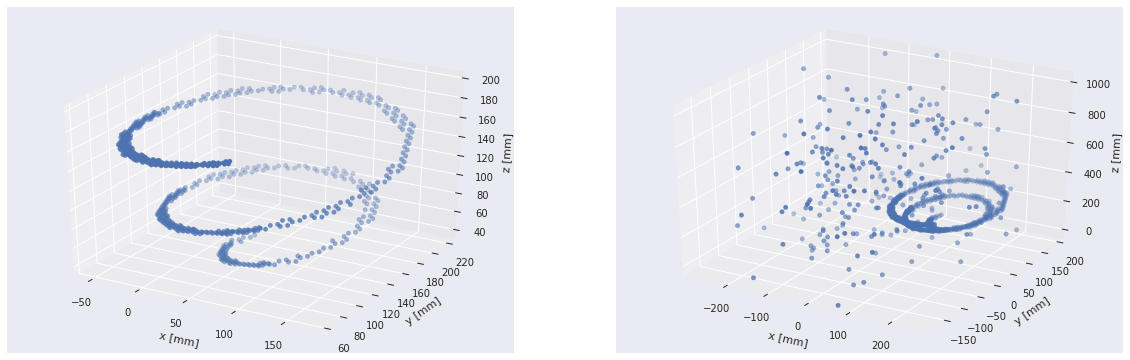

In [43]:
fig = plt.figure(figsize=(20, 14))

ax = fig.add_subplot(2, 2, 1, projection='3d')
ax.scatter(clean_xyzs[:,0], clean_xyzs[:,1], clean_xyzs[:,2])
ax.axis('equal')
#ax.set_title("Original Data")
ax.set_xlabel('\n x [mm]')
ax.set_ylabel('\n y [mm]')
ax.set_zlabel('\n z [mm]')


#######################################################################################################################
ax = fig.add_subplot(2, 2, 2, projection='3d')
ax.scatter(noise_xyzs[:,0], noise_xyzs[:,1], noise_xyzs[:,2])
ax.axis('equal')
#ax.set_title('Efficiently Downsampled Data')
ax.set_xlabel('\n x [mm]')
ax.set_ylabel('\n y [mm]')
ax.set_zlabel('\n z [mm]')

#plt.savefig('../plots/results/thesis/add-noise-3D.pdf')

# Compare to discretized

In [ ]:
DETECTOR_LENGTH = 1000.0
DETECTOR_RADIUS = 275.0

x_disc = 20
y_disc = 20
z_disc = 20

discElements = x_disc*y_disc*z_disc

x_inc = (2*DETECTOR_RADIUS)/x_disc
y_inc = (2*DETECTOR_RADIUS)/y_disc
z_inc = DETECTOR_LENGTH/z_disc

In [ ]:
discretized_dataClean = np.zeros((1, discElements))
discretized_xyzClean = np.zeros([clean_xyzs.shape[0], clean_xyzs.shape[1]])

num_pts = 0

for point in clean_xyzs:
    x_bucket = math.floor(((point[0]+DETECTOR_RADIUS)/(2*DETECTOR_RADIUS))*x_disc)
    y_bucket = math.floor(((point[1]+DETECTOR_RADIUS)/(2*DETECTOR_RADIUS))*y_disc)
    z_bucket = math.floor((point[2]/DETECTOR_LENGTH)*z_disc)

    bucket_num = z_bucket*x_disc*y_disc + x_bucket + y_bucket*x_disc
    
    avg_x = -DETECTOR_RADIUS + ((2*x_bucket+1)*x_inc)/2.0
    avg_y = -DETECTOR_RADIUS + ((2*y_bucket+1)*y_inc)/2.0
    avg_z = ((2*z_bucket+1)*z_inc)/2.0        
    
#     if(discretized_dataClean[0, bucket_num] == 1):
#         print("Duplicate Found")
#         discretized_xyzClean[num_pts] = [avg_x, avg_y, avg_z, point[3], point[4]]
#     else:
    discretized_dataClean[0,bucket_num] = 1                  
    discretized_xyzClean[num_pts] = [avg_x, avg_y, avg_z, point[3], point[4]]
    
    num_pts += 1

print("buckets filled: " + str(discretized_dataClean.sum()))

In [ ]:
discretized_dataNoise = np.zeros((1, discElements))
discretized_xyzNoise = np.zeros([noise_xyzs.shape[0], noise_xyzs.shape[1]])

num_pts = 0

for point in noise_xyzs:
    x_bucket = math.floor(((point[0]+DETECTOR_RADIUS)/(2*DETECTOR_RADIUS))*x_disc)
    y_bucket = math.floor(((point[1]+DETECTOR_RADIUS)/(2*DETECTOR_RADIUS))*y_disc)
    z_bucket = math.floor((point[2]/DETECTOR_LENGTH)*z_disc)

    bucket_num = z_bucket*x_disc*y_disc + x_bucket + y_bucket*x_disc
    discretized_dataNoise[0,bucket_num] = 1

    avg_x = -DETECTOR_RADIUS + ((2*x_bucket+1)*x_inc)/2.0
    avg_y = -DETECTOR_RADIUS + ((2*y_bucket+1)*y_inc)/2.0
    avg_z = ((2*z_bucket+1)*z_inc)/2.0                          
        
    discretized_xyzNoise[num_pts] = [avg_x, avg_y, avg_z, point[3], point[4]]
    
    num_pts += 1

print("buckets filled: " + str(discretized_dataNoise.sum()))

In [ ]:
print(discretized_xyzClean)
#discretized_data_sparse_CHARGE  = sp.sparse.csr_matrix((discretized_xyzClean), shape=(1, discElements))

In [ ]:
fig, ax = plt.subplots(2, 2, squeeze=True, figsize=(14, 14))

ax[0][0].plot(clean_xyzs[:,0], clean_xyzs[:,1], '.')
ax[0][0].axis('equal')
        
ax[0][0].set_xlabel('x [mm]')
ax[0][0].set_ylabel('y [mm]')
ax[0][0].set_title('Original Data - Clean')

#######################################################################################################################
ax[0][1].plot(discretized_xyzClean[:,0], discretized_xyzClean[:,1], '.')
ax[0][1].axis('equal')
        
ax[0][1].set_xlabel('x [mm]')
ax[0][1].set_ylabel('y [mm]')
ax[0][1].set_title('Discretized Data - Clean')

#######################################################################################################################
ax[1][0].plot(noise_xyzs[:,0], noise_xyzs[:,1], '.')
ax[1][0].axis('equal')
        
ax[1][0].set_xlabel('x [mm]')
ax[1][0].set_ylabel('y [mm]')
ax[1][0].set_title('Original Data - Noise')

#######################################################################################################################
ax[1][1].plot(discretized_xyzNoise[:,0], discretized_xyzNoise[:,1], '.')
ax[1][1].axis('equal')
        
ax[1][1].set_xlabel('x [mm]')
ax[1][1].set_ylabel('y [mm]')
ax[1][1].set_title('Discretized Data - Clean')

#plt.savefig('/home/taylor/Documents/independent-research/plots/events/noiseComparisonXY.pdf')

In [ ]:
ch_colors = sns.cubehelix_palette(n_colors=6, start=0, rot=-0.4,
                                  gamma=1, hue=1, light=0.75, dark=0.1)
ch_cm = sns.blend_palette(ch_colors, as_cmap=True)

In [ ]:
fig = plt.figure(figsize=(16, 16))

ax = fig.add_subplot(2, 2, 1, projection='3d')
ax.scatter(clean_xyzs[:,0], clean_xyzs[:,1], clean_xyzs[:,2], cmap=ch_cm, norm=LogNorm(), c=clean_xyzs[:,3])
ax.axis('equal')
ax.set_title("Original Data - Clean")

#######################################################################################################################
ax = fig.add_subplot(2, 2, 2, projection='3d')
ax.scatter(discretized_xyzClean[:,0], discretized_xyzClean[:,1], discretized_xyzClean[:,2], cmap=ch_cm, norm=LogNorm(), c=discretized_xyzClean[:,3])
ax.axis('equal')
ax.set_title('Discretized Data - Clean')

#######################################################################################################################
ax = fig.add_subplot(2, 2, 3, projection='3d')
ax.scatter(noise_xyzs[:,0], noise_xyzs[:,1], noise_xyzs[:,2], cmap=ch_cm, norm=LogNorm(), c=noise_xyzs[:,3])
ax.axis('equal')
ax.set_title('Original Data - Noise')

############################clean_xyzs###########################################################################################
ax = fig.add_subplot(2, 2, 4, projection='3d')
ax.scatter(discretized_xyzNoise[:,0], discretized_xyzNoise[:,1], discretized_xyzNoise[:,2], cmap=ch_cm, norm=LogNorm(), c=discretized_xyzNoise[:,3])
ax.axis('equal')
ax.set_title('Discretized Data - Noise')

#plt.savefig('/home/taylor/Documents/independent-research/plots/events/noiseComparison3D.pdf')

# pad num -> xy

In [ ]:
nums = np.random.randint(0,10240, (num_noisepts, 1))

In [ ]:
pads = pytpc.generate_pad_plane()
pcenters = pads.mean(1)

In [ ]:
xys = pcenters[nums]

In [ ]:
print(xys)

In [ ]:
print(xys.reshape(xys.shape[0], 2).shape)